In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import nasdaqdatalink

<Axes: title={'center': 'Unemployment rate (US) - monthly'}, xlabel='Date'>

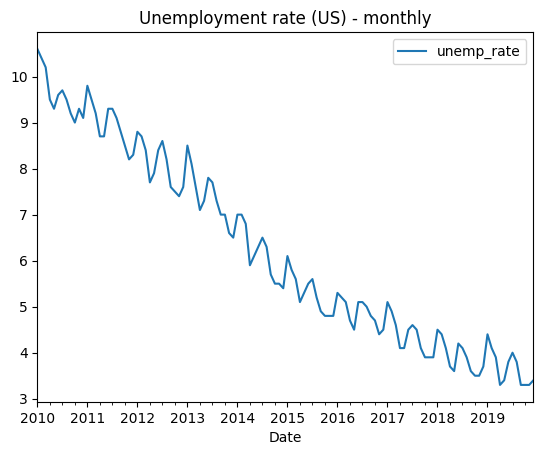

In [8]:
df = (
 nasdaqdatalink.get(dataset="FRED/UNRATENSA",
 start_date="2010-01-01",
 end_date="2019-12-31")
 .rename(columns={"Value": "unemp_rate"})
)
df.plot(title="Unemployment rate (US) - monthly")

In [10]:
# Create simple features:
df["linear_trend"] = range(len(df))
df["month"] = df.index.month

In [11]:
# Use one-hot encoding for the month feature:
month_dummies = pd.get_dummies(
 df["month"], drop_first=True, prefix="month"
)
df = df.join(month_dummies) \
 .drop(columns=["month"])

In [12]:
# Separate the target from the features:
X = df.copy()
y = X.pop("unemp_rate")

In [13]:
# Define the expanding window walk-forward validation and print the indices of the folds:
expanding_cv = TimeSeriesSplit(n_splits=5, test_size=12)
for fold, (train_ind, valid_ind) in enumerate(expanding_cv.split(X)):
 print(f"Fold {fold} ----")
 print(f"Train indices: {train_ind}")
 print(f"Valid indices: {valid_ind}")

Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

In [14]:
# Evaluate the model’s performance using the expanding window validation:
scores = []
for train_ind, valid_ind in expanding_cv.split(X):
 lr = LinearRegression()
 lr.fit(X.iloc[train_ind], y.iloc[train_ind])
 y_pred = lr.predict(X.iloc[valid_ind])
 scores.append(
 mean_absolute_percentage_error(y.iloc[valid_ind], y_pred)
 )
print(f"Scores: {scores}")
print(f"Avg. score: {np.mean(scores)}")

Scores: [0.03705079312389487, 0.07828415627306319, 0.11981060282172921, 0.16829494012910826, 0.25460459651634104]
Avg. score: 0.13160901777282732


In [15]:
# Instead of iterating over the splits, we can easily use the cross_validate function from scikitlearn:
cv_scores = cross_validate(
 LinearRegression(),
 X, y,
 cv=expanding_cv,
 scoring=["neg_mean_absolute_percentage_error",
 "neg_root_mean_squared_error"]
)
pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.016103,0.018028,-0.037051,-0.232500
1,0.022356,0.003700,-0.078284,-0.433547
2,0.019932,0.003795,-0.119811,-0.520073
3,0.023880,0.003721,-0.168295,-0.662540
4,0.019449,0.005523,-0.254605,-0.928998


In [16]:
# Define the sliding window validation and print the indices of the folds:
sliding_cv = TimeSeriesSplit(
 n_splits=5, test_size=12, max_train_size=60
)
for fold, (train_ind, valid_ind) in enumerate(sliding_cv.split(X)):
 print(f"Fold {fold} ----")
 print(f"Train indices: {train_ind}")
 print(f"Valid indices: {valid_ind}")

Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 9

In [17]:
# Evaluate the model’s performance using the sliding window validation:
cv_scores = cross_validate(
 LinearRegression(),
 X, y,
 cv=sliding_cv,
 scoring=["neg_mean_absolute_percentage_error",
 "neg_root_mean_squared_error"]
)
pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.005436,0.004264,-0.037051,-0.232500
1,0.004453,0.002567,-0.097125,-0.524333
2,0.004207,0.002828,-0.126609,-0.550749
3,0.004153,0.002613,-0.129454,-0.518194
4,0.004255,0.002861,-0.108759,-0.407428
